# Homework 2: Language in the 2016 Presidential Election
Popular figures often have help managing their media presence.  In the 2016 election, Twitter was an important communication medium for every major candidate.  Many Twitter posts posted by the top two candidates were actually written by their aides.  You might wonder how this affected the content or language of the tweets.

In this assignment, we'll look at some of the patterns in tweets by the top two candidates, Clinton and Trump.  We'll start with Clinton.

Along the way, you'll get a first look at Pandas.  Pandas is a Python package that provides a `DataFrame` data structure similar to the `datascience` package's `Table`, which you might remember from Data 8.  `DataFrame`s are a bit harder to use than `Table`s, but they provide more advanced functionality and are a standard tool for data analysis in Python.

Some of the analysis in this assignment is based on a [post by David Robinson](http://varianceexplained.org/r/trump-tweets/).  Feel free to read the post, but do not copy from it!  David's post is written in the `R` programming language, which is a favorite of many data analysts, especially academic statisticians.  Once you're done with your analysis, you may find it interesting to see whether `R` is easier to use for this task.

To start the assignment, run the cell below to set up some imports and the automatic tests.

In [1]:
import math
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

!pip install -U okpy
from client.api.notebook import Notebook
ok = Notebook('hw2.ok')

/bin/sh: pip: command not found
Assignment: Homework 2
OK, version v1.11.1



## Getting the dataset
Since we'll be looking at Twitter data, we need to download the data from Twitter!

Twitter provides an API for downloading tweet data in large batches.  The `tweepy` package makes it fairly easy to use.

#### Question 0
Install `tweepy`, if you don't already have it.  (Be sure to activate your Conda environment for the class first.  Then run `pip install tweepy`.)

There are instructions on using `tweepy` [here](http://tweepy.readthedocs.io/en/v3.5.0/getting_started.html), but we will give you example code.

Twitter requires you to have authentication keys to access their API.  To get your keys, you'll have to sign up as a Twitter developer.

#### Question 1
Follow these instructions to get your keys:

1. [Create a Twitter account](https://twitter.com).  You can use an existing account if you have one.
2. Under account settings, add your phone number to the account.
3. [Create a Twitter developer account](https://dev.twitter.com/resources/signup).  Attach it to your Twitter account.
4. Once you're logged into your developer account, [create an application for this assignment](https://apps.twitter.com/app/new).  You can call it whatever you want, and you can write any URL when it asks for a web site.
5. On the page for that application, find your Consumer Key and Consumer Secret.
6. On the same page, create an Access Token.  Record the resulting Access Token and Access Token Secret.
7. Edit the file [keys.json](keys.json) and replace the placeholders with your keys.  Don't turn in that file.

## I AM AN IMPORTANT NOTE.  DO NOT SKIP ME.
If someone has your authentication keys, they can access your Twitter account and post as you!  So don't give them to anyone, and **don't write them down in this notebook**.  The usual way to store sensitive information like this is to put it in a separate file and read it programmatically.  That way, you can share the rest of your code without sharing your keys.  That's why we're asking you to put your keys in `keys.json` for this assignment.

## I AM A SECOND IMPORTANT NOTE.
Twitter limits developers to a certain rate of requests for data.  If you make too many requests in a short period of time, you'll have to wait awhile (around 15 minutes) before you can make more.  So carefully follow the code examples you see and don't rerun cells without thinking.  Instead, always save the data you've collected to a file.  We've provided templates to help you do that.

In the example below, we have loaded some tweets by @BerkeleyData.  Run it, inspect the output, and read the code.

In [2]:
ds_tweets_save_path = "BerkeleyData_recent_tweets.pkl"
from pathlib import Path
# Guarding against attempts to download the data multiple
# times:
if not Path(ds_tweets_save_path).is_file():
    import json
    # Loading your keys from keys.json (which you should have filled
    # in in question 1):
    with open("keys.json") as f:
        keys = json.load(f)

    import tweepy

    # Authenticating:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)

    # Getting as many recent tweets by @BerkeleyData as Twitter will let us have:
    example_tweets = list(tweepy.Cursor(api.user_timeline, id="BerkeleyData").items())

    # Saving the tweets to a file as "pickled" objects:
    with open(ds_tweets_save_path, "wb") as f:
        import pickle
        pickle.dump(example_tweets, f)

# Re-loading the results:
with open(ds_tweets_save_path, "rb") as f:
    import pickle
    example_tweets = pickle.load(f)

In [3]:
# Looking at one tweet object, which has type Status:
example_tweets[0]
# You can try something like this:
#   import pprint; pprint.pprint(vars(example_tweets[0]))
# ...to get a more easily-readable view.

Status(_json={'created_at': 'Wed May 17 16:09:49 +0000 2017', 'id': 864875612669747200, 'id_str': '864875612669747200', 'text': 'Using Technology to Address Gender Bias in Film: Learn more, via Google: https://t.co/LXcSgwa0Yk #datascience', 'truncated': False, 'entities': {'hashtags': [{'text': 'datascience', 'indices': [97, 109]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/LXcSgwa0Yk', 'expanded_url': 'http://bit.ly/2m4bgfw', 'display_url': 'bit.ly/2m4bgfw', 'indices': [73, 96]}]}, 'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1227698863, 'id_str': '1227698863', 'name': 'datascience@berkeley', 'screen_name': 'BerkeleyData', 'location': 'Berkeley, CA', 'description': 'An online Master of Information and Data Science (MIDS) degree from the UC Berkeley Scho

#### Question 2
Write code to download all the recent tweets by Hillary Clinton (@HillaryClinton).  Follow our example code if you wish.  Write your code in the form of four **functions** matching the documentation provided.  (You may define additional functions as helpers.)  **Once you've written your functions,** you can run the subsequent cell to download the tweets.

In [4]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    import json
    with open(path) as f:
        return json.load(f)

def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Status objects, each representing one tweet."""
    import tweepy

    # Authenticating:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)

    return list(tweepy.Cursor(api.user_timeline, id=user_account_name).items())

def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Status) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    with open(path, "wb") as f:
        import pickle
        pickle.dump(tweets, f)
    
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Status objects, each representing one tweet."""
    with open(path, "rb") as f:
        import pickle
        return pickle.load(f)

In [5]:
# When you are done, run this cell to load @HillaryClinton's tweets.
# Note the function get_tweets_with_cache.  You may find it useful
# later.

def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    save_path = "{}_recent_tweets.pkl".format(user_account_name)
    from pathlib import Path
    if not Path(save_path).is_file():
        keys = load_keys(keys_path)
        tweets = download_recent_tweets_by_user(user_account_name, keys)
        save_tweets(tweets, save_path)
    return load_tweets(save_path)

In [6]:
clinton_tweets = get_tweets_with_cache("HillaryClinton", "keys.json")

In [7]:
# If everything is working properly, this should print out
# a Status object (a single tweet).  clinton_tweets should
# contain around 3000 tweets.
clinton_tweets[0]

Status(_json={'created_at': 'Sat Jun 03 03:08:26 +0000 2017', 'id': 870839564914634760, 'id_str': '870839564914634760', 'text': 'Today we remember Hadiya, &amp; all victims of gun violence. Proud of these young dynamos &amp; all those committed to the… https://t.co/Hhp1lVF25Z', 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/Hhp1lVF25Z', 'expanded_url': 'https://twitter.com/i/web/status/870839564914634760', 'display_url': 'twitter.com/i/web/status/8…', 'indices': [124, 147]}]}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1339835893, 'id_str': '1339835893', 'name': 'Hillary Clinton', 'screen_name': 'HillaryClinton', 'location': 'New York, NY', 'description': 'Wife, mom, grandma, women+kids advocat

In [8]:
_ = ok.grade('q02')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Could not save your notebook. Make sure your notebook is saved before sending it to OK!
Backup... 100% complete
Backup successful for user: doomsplayer@gmail.com



### Exploring the dataset
Twitter gives us a lot of information about each tweet, not just its text.  You can read the full documentation [here](https://dev.twitter.com/overview/api/tweets).  Look at one tweet to get a sense of the information we have available.

#### Question 3
Which fields contain:
1. the actual text of a tweet,
2. the time when the tweet was posted, and
3. the source (device and app) from which the tweet was posted?

To answer the question, write functions that extract each field from a tweet.  (Each one should take a single Status object as its argument.)

In [9]:
def extract_text(tweet):
    return tweet.text #SOLUTION

def extract_time(tweet):
    return tweet.created_at #SOLUTION

def extract_source(tweet):
    return tweet.source #SOLUTION

In [10]:
_ = ok.grade('q03')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Could not save your notebook. Make sure your notebook is saved before sending it to OK!
Backup... 100% complete
Backup successful for user: doomsplayer@gmail.com



#### Question 4
Are there any other fields you think might be useful in identifying the true author of an @HillaryClinton tweet?  (If you're reading the documentation, consider whether fields are actually present often enough in the data to be useful.)

**SOLUTION:** Some possible answers: `retweet_count` or `favorite_count` might be useful if we think tweets by the candidate herself are retweeted or favorited more often.  `coordinates` might be useful if we can identify some pattern in the aides' or candidate's locations (for example, if the aides always tweet from the same campaign office building, which Hillary rarely visits).  `quoted_status` might be useful if aides are more likely to quote other tweets than the candidate herself.

## Building a Pandas table
JSON (and the Status object, which is just Tweepy's translation of the JSON produced by the Twitter API to a Python object) is nice for transmitting data, but it's not ideal for analysis.  The data will be easier to work with if we put them in a table.

To create an empty table in Pandas, write:

In [11]:
import pandas as pd
df = pd.DataFrame()

(`pd` is the standard abbrevation for Pandas.)

Now let's make a table with useful information in it.  To add a column to a DataFrame called `df`, write:
    
    df['column_name'] = some_list_or_array

([This page](http://pandas.pydata.org/pandas-docs/stable/10min.html) is a useful reference for many of the basic operations in Pandas.  You don't need to read it now, but it might be helpful if you get stuck.)

#### Question 5
Write a function called `make_dataframe`.  It should take as its argument a list of tweets like `clinton_tweets` and return a Pandas DataFrame.  The DataFrame should contain columns for all the fields in question 3 and any fields you listed in question 4.  **Use the field names as the names of the corresponding columns.**

In [12]:
def make_dataframe(tweets):
    """Make a DataFrame from a list of tweets, with a few relevant fields.
    
    Args:
        tweets (list): A list of tweets, each one a Status object.
    
    Returns:
        DataFrame: A Pandas DataFrame containing one row for each element
          of tweets and one column for each relevant field."""
    df = pd.DataFrame() #SOLUTION
    df['text'] = [extract_text(t) for t in tweets] #SOLUTION
    df['created_at'] = [extract_time(t) for t in tweets] #SOLUTION
    df['source'] = [extract_source(t) for t in tweets] #SOLUTION
    return df

Now you can run the next line to make your DataFrame.

In [13]:
clinton_df = make_dataframe(clinton_tweets)

In [14]:
# The next line causes Pandas to display all the characters
# from each tweet when the table is printed, for more
# convenient reading.  Comment it out if you don't want it.
pd.set_option('display.max_colwidth', 150)

clinton_df.head()

,text,created_at,source
0,"Today we remember Hadiya, &amp; all victims of gun violence. Proud of these young dynamos &amp; all those committed to the… https://t.co/Hhp1lVF25Z",2017-06-03 03:08:26,Twitter for iPhone
1,A historic mistake. The world is moving forward together on climate change. Paris withdrawal leaves American workers &amp; families behind.,2017-06-01 23:38:34,Twitter for iPhone
2,People in covfefe houses shouldn't throw covfefe. https://t.co/M7oK5Z6qwF,2017-06-01 01:30:20,Twitter for iPhone
3,"Going on stage now, watch live! https://t.co/kkhepdwIkK",2017-05-31 19:15:53,Twitter for iPhone
4,A rainy but wonderful morning march in the Chappaqua Memorial Day Parade. Thinking of our veterans who gave their l… https://t.co/NJMFNxqtsK,2017-05-29 16:59:50,Twitter for iPhone


In [15]:
_ = ok.grade('q05')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'hw2.ipynb'.
Backup... 100% complete
Backup successful for user: doomsplayer@gmail.com



## Tweetsourcing
Now that the preliminaries are done, we can do what we set out to do: Try to distinguish between Clinton's own tweets and her aides'.

#### Question 6
Create a plot showing how many tweets came from each kind of source.  For a real challenge, try using the Pandas documentation and Google to figure out how to do this.  Otherwise, hints are provided.

*Hint:* Start by grouping the data by source.  `df['source'].value_counts()` will create an object called a Series (which is like a table that contains exactly 2 columns, where one column is called the *index*).  You can create a version of that Series that's sorted by source (in this case, in alphabetical order) by calling `sort_index()` on it.

*Hint 2:* To generate a bar plot from a Series `s`, call `s.plot.barh()`.  You can also use `matplotlib`'s [`plt.barh`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.barh), but it's a little bit complicated to use.

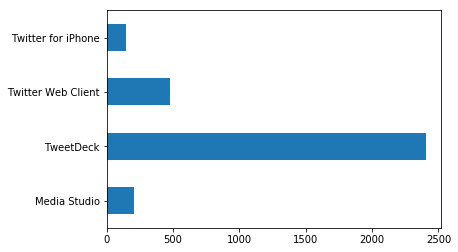

In [16]:
clinton_df['source'].value_counts().sort_index().plot.barh(); #SOLUTION

You should find that most tweets come from [TweetDeck](https://tweetdeck.twitter.com).

#### Question 7
Filter `clinton_df` to examine some tweets from TweetDeck and a few from the next-most-used platform.  From examining only a few tweets (say 10 from each category), can you tell whether Clinton's personal tweets are limited to one platform?

*Hint:* If `df` is a DataFrame and `filter_array` is an array of booleans of the same length, then `df[filter_array]` is a new DataFrame containing only the rows in `df` corresponding to `True` values in `filter_array`.

In [17]:
# Do your analysis, then write your conclusions in a brief comment.
tweetdeck = clinton_df[clinton_df['source'] == 'TweetDeck']
twc = clinton_df[clinton_df['source'] == 'Twitter Web Client']
import numpy as np
def rounded_linspace(start, stop, count):
    import numpy as np
    return np.linspace(start, stop, count, endpoint=False).astype(int)
print(tweetdeck.iloc[rounded_linspace(0, tweetdeck.shape[0], 10)]['text'])
print(twc.iloc[rounded_linspace(0, twc.shape[0], 10)]['text'])

# It does look like Twitter Web Client is used more for retweeting,
# but it's not obvious which tweets are by Hillary.

81           Scripture tells us: Let us not grow weary in doing good, for in due season, we shall reap, if we do not lose heart. https://t.co/snXfdLgZq8
441          "That’s what’s on the ballot this year. It’s not just my name and Donald Trump’s name. It’s our future. Our security. Our values." —Hillary
746                                                             Watch live: @POTUS hits the campaign trail for Hillary in Miami. https://t.co/lFWJRhSouE
1107                                   Americans deserve a real plan to expand access to health care and get costs down. https://t.co/6J5vpfTxhs #debate
1476                                                                                                                 "Whew, OK!” https://t.co/385hydBQan
1820        The next 53 days will shape the next 50 years.\n\nThe future of our children and grandchildren hangs in the balance. https://t.co/tTgeqxNqYm
2115    Unions gave us higher wages, weekends, and the largest middle class in the

## When in doubt, read...
Check Hillary Clinton's [Twitter page](http://twitter.com/HillaryClinton).  It mentions an easy way to identify tweets by the candidate herself.  All other tweets are by her aides.

#### Question 8
Write a function called `is_clinton` that takes a tweet (in JSON) as its argument and returns `True` for personal tweets by Clinton and `False` for tweets by her aides.  Use your function to create a column called `is_personal` in `clinton_df`.

*Hint:* You might find the string method `endswith` helpful.

In [18]:
def is_clinton(tweet):
    """Distinguishes between tweets by Clinton and tweets by her aides.
    
    Args:
        tweet (Status): One tweet.
    
    Returns:
        bool: True if the tweet is written by Clinton herself."""
    return extract_text(tweet).endswith("-H") #SOLUTION

clinton_df['is_personal'] = [is_clinton(t) for t in clinton_tweets] #SOLUTION

Now we have identified Clinton's personal tweets.  Let us return to our analysis of sources and see if there was any pattern we could have found.

You may recall that Tables from Data 8 have a method called `pivot`, which is useful for cross-classifying a dataset on two categorical attrbiutes.  DataFrames support a more complicated version of pivoting.  The cell below pivots `clinton_df` for you.

In [19]:
# This cell is filled in for you; just run it and examine the output.
def pivot_count(df, vertical_column, horizontal_column):
    """Cross-classifies df on two columns."""
    pivoted = pd.pivot_table(df[[vertical_column, horizontal_column]], index=[vertical_column], columns=[horizontal_column], aggfunc=len, fill_value=0)
    return pivoted.rename(columns={False: "False", True: "True"})

clinton_pivoted = pivot_count(clinton_df, 'source', 'is_personal')
clinton_pivoted

is_personal,False,True
source,,
Media Studio,207,0
TweetDeck,2373,30
Twitter Web Client,463,14
Twitter for iPhone,138,6


Do Clinton and her aides have different "signatures" of tweet sources?  That is, for each tweet they send, does Clinton send tweets from each source with roughly the same frequency as her aides?  It's a little hard to tell from the pivoted table alone.

#### Question 9
Create a visualization to facilitate that comparison.

*Hint:* `df.plot.barh` works for DataFrames, too.  But think about what data you want to plot.

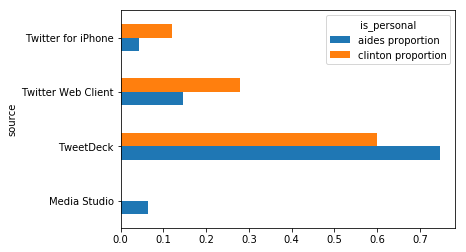

In [20]:
clinton_pivoted["aides proportion"] = clinton_pivoted['False'] / sum(clinton_pivoted['False'])
clinton_pivoted["clinton proportion"] = clinton_pivoted['True'] / sum(clinton_pivoted['True'])
clinton_pivoted[["aides proportion", "clinton proportion"]].plot.barh();

You should see that there are some differences, but they aren't large.  Do we need to worry that the differences (or lack thereof) are just "due to chance"?

Statistician Ani argues as follows:

> "The tweets we see are not a random sample from anything.  We have simply gathered every tweet by @HillaryClinton from the last several months.  It is therefore meaningless to compute, for example, a confidence interval for the rate at which Clinton used TweetDeck.  We have calculated exactly that rate from the data we have."

Statistician Belinda responds:

> "We are interested in whether Clinton and her aides *behave differently in general* with respect to Twitter client usage in a way that we could use to identify their tweets.  It's plausible to imagine that the tweets we see are a random sample from a huge unobserved population of all the tweets Clinton and her aides *might send*.  We must worry about error due to random chance when we draw conclusions about this population using only the data we have available."

#### Question 10
What position would you take on this question?  Choose a side and give one (brief) argument for it, or argue for some third position.

**SOLUTION:** Here is an argument for Belinda's position.  Imagine that Clinton had tweeted only 5 times.  Then we would probably not think we could come to a valid conclusion about her behavior patterns.  So there is a distinction between the data and an underlying parameter that we're trying to learn about.  *However*, this does not mean it's reasonable to use methods (like the simple bootstrap) that assume the data are a *simple* random sample from the population we're interested in.

#### Question 11
Assume you are convinced by Belinda's argument.  Perform a statistical test of the null hypothesis that the Clinton and aide tweets' sources are all independent samples from the same distribution (that is, that the differences we observe are "due to chance").  Briefly describe the test methodology and report your results.

*Hint:* If you need a refresher, [this section](https://www.inferentialthinking.com/chapters/16/1/two-categorical-distributions.html) of the Data 8 textbook from Fall 2016 covered this kind of hypothesis test.

*Hint 2:* Feel free to use `datascience.Table` to answer this question.  However, it will be advantageous to learn how to do it with `numpy` alone.  In our solution, we used some `numpy` functions you might not be aware of: `np.append`, `np.random.permutation`, `np.bincount`, and `np.count_nonzero`.  We have provided the function `expand_counts`, which should help you solve a tricky problem that will arise.

In [21]:
# Use this cell to perform your hypothesis test.

def expand_counts(source_counts):
    """Blow up a list/array of counts of categories into an array of
    individuals matching the counts.  For example, we can generate
    a list of 2 individuals of type 0, 4 of type 1, and 1 of type 3
    as follows:
    
    >>> expand_counts([2, 4, 0, 1])
    array([0, 0, 1, 1, 1, 1, 3])"""
    return np.repeat(np.arange(len(source_counts)), source_counts)

def tvd(a, b):
    return .5*sum(np.abs(a/sum(a) - b/sum(b)))

def test_difference_in_distributions(sample0, sample1, num_trials):
    num_sources = len(sample0)
    individuals0 = expand_counts(sample0)
    individuals1 = expand_counts(sample1)
    count0 = len(individuals0)
    count1 = len(individuals1)
    all_individuals = np.append(individuals0, individuals1)
    def simulate_under_null():
        permuted_pool = np.random.permutation(all_individuals)
        simulated_sample0 = np.bincount(permuted_pool[:count0], minlength=num_sources)
        simulated_sample1 = np.bincount(permuted_pool[count0:], minlength=num_sources)
        return tvd(simulated_sample0, simulated_sample1)
        
    actual_tvd = tvd(sample0, sample1)
    simulated_tvds = np.array([simulate_under_null() for _ in range(num_trials)])
    return np.count_nonzero(simulated_tvds > actual_tvd) / num_trials

p_value = test_difference_in_distributions(clinton_pivoted['True'], clinton_pivoted['False'], 100000)
print("P-value: {:.6f}".format(p_value))



P-value: 0.001150


**SOLUTION:** We simulated many times under the null hypothesis by pooling the data and permuting the sources.  We found a P-value around .04%, so we have very strong evidence against the null hypothesis that Clinton and her aides tweet from the same distribution of sources.  It's important to note that strong evidence that the difference *is not zero* (which we have found) is very different from evidence that the difference is *large* (which we have not found).  The next question demonstrates this.

#### Question 12
Suppose you sample a random @HillaryClinton tweet and find that it is from the Twitter Web Client.  Your visualization in question 9 should show you that Clinton tweets from this source about twice as frequently as her aides do, so you might imagine it's reasonable to predict that the tweet is by Clinton.  But what is the probability that the tweet is by Clinton?  (You should find a relatively small number.  Clinton's aides tweet much more than she does.  So even though there is a difference in their tweet source usage, it would be difficult to classify tweets this way.)

*Hint:* Bayes' rule is covered in [this section](https://www.inferentialthinking.com/chapters/17/1/more-likely-than-not-binary-classifier.html) of the Data 8 textbook.

In [22]:
probability_clinton = clinton_pivoted.loc['Twitter Web Client']['True'] / sum(clinton_pivoted.loc['Twitter Web Client']) #SOLUTION
probability_clinton

0.029323943701294066

In [23]:
_ = ok.grade('q12')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Could not save your notebook. Make sure your notebook is saved before sending it to OK!
Backup... 100% complete
Backup successful for user: doomsplayer@gmail.com



# Another candidate
Our results so far aren't Earth-shattering.  Clinton uses different Twitter clients at slightly different rates than her aides.

Now that we've categorized the tweets, we could of course investigate their contents.  A manual analysis (also known as "reading") might be interesting, but it is beyond the scope of this course.  And we'll have to wait a few more weeks before we can use a computer to help with such an analysis.

Instead, let's repeat our analysis for Donald Trump.

#### Question 13
Download the tweet data for Trump (@realDonaldTrump), and repeat the steps through question 6 to create a table called `trump_df`.

In [24]:
trump_tweets = get_tweets_with_cache("realDonaldTrump", "keys.json") #SOLUTION
trump_df = make_dataframe(trump_tweets) #SOLUTION

In [25]:
trump_df.head()

,text,created_at,source
0,Do you notice we are not having a gun debate right now? That's because they used knives and a truck!,2017-06-04 11:43:30,Twitter for iPhone
1,"At least 7 dead and 48 wounded in terror attack and Mayor of London says there is ""no reason to be alarmed!""",2017-06-04 11:31:00,Twitter for iPhone
2,We must stop being politically correct and get down to the business of security for our people. If we don't get smart it will only get worse,2017-06-04 11:19:47,Twitter for iPhone
3,"Whatever the United States can do to help out in London and the U. K., we will be there - WE ARE WITH YOU. GOD BLESS!",2017-06-03 23:24:45,Twitter for iPhone
4,"We need to be smart, vigilant and tough. We need the courts to give us back our rights. We need the Travel Ban as an extra level of safety!",2017-06-03 23:17:13,Twitter for iPhone


#### Question 14
Make a bar chart of the sources of Trump tweets.

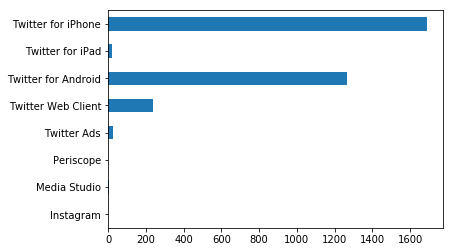

In [26]:
trump_df['source'].value_counts().sort_index().plot.barh(); #SOLUTION

You should find two major sources of tweets.

It is reported (for example, in [this Gawker article](http://gawker.com/our-trump-twitter-bot-filters-out-donald-trumps-new-han-1783906386)) that Trump himself uses an Android phone (a Samsung Galaxy), while his aides use iPhones.  But Trump has not confirmed this.  Also, he has reportedly [switched phones](http://indiatoday.intoday.in/technology/story/which-phone-will-president-donald-trump-use-a-blackberry-that-cant-even-click-pics/1/862350.html) since his inauguration!  How might we verify whether this is a way to identify his tweets?

A retweet is a tweet that replies to (or simply repeats) a tweet by another user.  Twitter provides several mechanisms for this, as explained in [this article](https://blog.hubspot.com/blog/tabid/6307/bid/27675/How-to-Retweet-the-Right-Way-in-4-Easy-Steps.aspx#sm.00001bz3cbt3sqe1kyf4eavc4lj9a).  However, Trump has an unusual way of retweeting: He simply adds the original sender's name to the original message, puts everything in quotes, and then adds his own comments at the end.

For example, this is a tweet by user @melissa7889:

        @realDonaldTrump @JRACKER33 you should run for president!

Here is Trump's retweet of this, from 2013:

        "@melissa7889: @realDonaldTrump @JRACKER33 you should run for president!" Thanks,very nice!

Since 2015, the usual way of retweeting this message, and the method used by Trump's aides (but not Trump himself), would have been:

        Thanks,very nice! RT @melissa7889: @realDonaldTrump @JRACKER33 you should run for president!

#### Question 15
Write a function to identify Trump-style retweets, and another function to identify the aide-style retweets.  Then, use them to create a function called `tweet_type` that takes a tweet as its argument and returns values `"Trump retweet"`, `"Aide retweet"`, and `"Not a retweet"` as appropriate.  Use your function to add a `'tweet_type'` column to `trump_df`.

*Hint:* Try the string method `startswith` and the Python keyword `in`.

In [27]:
def is_trump_style_retweet(tweet_text):
    """Returns True if tweet_text looks like a Trump-style retweet."""
    return tweet_text.startswith('"@')
    
def is_aide_style_retweet(tweet_text):
    """Returns True if tweet_text looks like an aide-style retweet."""
    return "RT @" in tweet_text

def tweet_type(tweet_text):
    """Returns "Trump retweet", "Aide retweet", or "Not a retweet"
    as appropriate."""
    if is_trump_style_retweet(tweet_text):
        return "Trump retweet"
    elif is_aide_style_retweet(tweet_text):
        return "Aide retweet"
    return "Not a retweet"

trump_df['tweet_type'] = [tweet_type(t) for t in trump_df['text']]

In [28]:
trump_df

,text,created_at,source,tweet_type
0,Do you notice we are not having a gun debate right now? That's because they used knives and a truck!,2017-06-04 11:43:30,Twitter for iPhone,Not a retweet
1,"At least 7 dead and 48 wounded in terror attack and Mayor of London says there is ""no reason to be alarmed!""",2017-06-04 11:31:00,Twitter for iPhone,Not a retweet
2,We must stop being politically correct and get down to the business of security for our people. If we don't get smart it will only get worse,2017-06-04 11:19:47,Twitter for iPhone,Not a retweet
3,"Whatever the United States can do to help out in London and the U. K., we will be there - WE ARE WITH YOU. GOD BLESS!",2017-06-03 23:24:45,Twitter for iPhone,Not a retweet
4,"We need to be smart, vigilant and tough. We need the courts to give us back our rights. We need the Travel Ban as an extra level of safety!",2017-06-03 23:17:13,Twitter for iPhone,Not a retweet
5,RT @DRUDGE_REPORT: Fears of new terror attack after van 'mows down 20 people' on London Bridge...,2017-06-03 23:01:54,Twitter for iPhone,Aide retweet
6,#WeeklyAddress🇺🇸 https://t.co/DNzRZiKxhd,2017-06-03 19:35:33,Twitter Ads,Not a retweet
7,#MakeAmericaGreatAgain🇺🇸\nhttps://t.co/eJxeVZ3A1r,2017-06-02 18:30:41,Twitter for iPhone,Not a retweet
8,RT @EricTrump: #MakeAmericaGreatAgain!!! 🇺🇸🇺🇸 https://t.co/MStWl628xe,2017-06-02 10:40:22,Twitter for iPhone,Aide retweet
9,RT @HeyTammyBruce: Coming up at 720a ET on @foxandfriends! See you there! 🇺🇸 #maga,2017-06-02 10:35:32,Twitter for iPhone,Aide retweet


In [29]:
_ = ok.grade('q15')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Could not save your notebook. Make sure your notebook is saved before sending it to OK!
Backup... 100% complete
Backup successful for user: doomsplayer@gmail.com



#### Question 16
Cross-classify @realDonaldTrump tweets by `source` and by `tweet_type` into a table called `trump_pivoted`.

*Hint:* We did something very similar after question 7.  You don't need to write much new code for this.

In [30]:
trump_pivoted = pivot_count(trump_df, 'source', 'tweet_type') #SOLUTION
trump_pivoted

tweet_type,Aide retweet,Not a retweet,Trump retweet
source,,,
Instagram,0,1,0
Media Studio,0,2,0
Periscope,0,1,0
Twitter Ads,0,27,0
Twitter Web Client,38,197,0
Twitter for Android,0,1043,222
Twitter for iPad,2,20,0
Twitter for iPhone,155,1531,4


In [31]:
_ = ok.grade('q16')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Could not save your notebook. Make sure your notebook is saved before sending it to OK!
Backup... 100% complete
Backup successful for user: doomsplayer@gmail.com



#### Question 17
Does the cross-classified table show evidence against the hypothesis that Trump and his advisors tweet from roughly the same sources?  Again assuming you agree with Statistician Belinda, run an hypothesis test in the next cell to verify that there is a difference in the relevant distributions.  Then use the subsequent cell to describe your methodology and results.  Are there any important caveats?

In [32]:
test_difference_in_distributions(trump_pivoted['Aide retweet'], trump_pivoted['Trump retweet'], 100000) #SOLUTION

0.0

**SOLUTION:** We eliminated the non-retweets and performed a test for a difference in categorical distributions as we did for Clinton.  As should obvious from the table, there is a difference!  (We find a P-value of 0, though this is approximate, and the true P-value is merely extremely close to 0.)  One small caveat is that we are looking only at retweets.  It's plausible that people behave differently when retweeting - maybe they find one device or app more convenient for retweets.  A bigger caveat is that we don't just care about there being *any* difference, but that the difference is *large*.  This is obvious from looking at the table - Trump almost never retweets from an iPhone and his aides never retweet from an Android phone.  (Since we care about magnitudes, it would be useful to create confidence intervals for the chances of Trump and his aides tweeting from various devices.  With a dataset this large, they would be narrow.)

We are really interested in knowing whether we can classify @realDonaldTrump tweets on the basis of the source.  Just knowing that there is a difference in source distributions isn't nearly enough.  Instead, we would like to claim something like this: "@realDonaldTrump tweets from Twitter for Android are generally authored by Trump himself.  Other tweets are generally authored by his aides."

#### Question 18
If you use bootstrap methods to compute a confidence interval for the proportion of Trump aide retweets from Android phones in "the population of all @realDonaldTrump retweets," you will find that the interval is [0, 0].  That's because there are no retweets from Android phones by Trump aides in our dataset.  Is it reasonable to conclude from this that Trump aides definitely never tweet from Android phones?

**SOLUTION:** No, the bootstrap is misleading in this case.  If we'd seen 1 million retweets by Trump aides, it might be okay to make this conclusion.  But we have seen only 177, so the conclusion seems a bit premature.

# Submitting your assignment
First, run the next cell to run all the tests at once.

In [ ]:
_ = ok.grade_all()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------

Now, run this code in your terminal to make a
[git commit](https://www.atlassian.com/git/tutorials/saving-changes/git-commit)
that saves a snapshot of your changes in `git`. The last line of the cell
runs [git push](http://stackoverflow.com/questions/2745076/what-are-the-differences-between-git-commit-and-git-push), which will send your work to your personal Github repo.

**Note:** Don't add and commit your `keys.json` file!  `git add -A` will do that, but the code we've written below won't.

    # Tell git to commit your changes to this notebook
    git add sp17/hw/hw2/hw2.ipynb
    
    # Tell git to make the commit
    git commit -m "hw2 finished"
    
    # Send your updates to your personal private repo
    git push origin master

Finally, we'll submit the assignment to OkPy so that the staff will know to grade it. You can submit as many times as you want, and you can choose which submission you want us to grade by going to https://okpy.org/cal/data100/sp17/.

In [ ]:
# Now, we'll submit to okpy
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... 

Congratulations, you're done!

We've only scratched the surface of this dataset.  Twitter is a rich source of data about language and social interaction, and not only for political figures.  Now you know how to access it!